# TravelTide Company
- EDA & adding columns on user_lever_table and creating a perks column

In [4]:
import pandas as pd

user_level_df = pd.read_csv("/Users/biancaniemann/Documents/VS Code/Practice Python/Travel Tide Project/TravelTide_Final_Files/user_level_df.csv")

In [1]:
!pip install -q pandasql
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

In [ ]:
# Added the scaled ADS using python as when I tried to add the column using SQL I kept getting errors, probably wont use in segmentation but thought good to have incase

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
user_level_df['scaled_ADS'] = scaler.fit_transform(user_level_df[['ADS_flights']])

In [26]:
# Resave user_level_df to include the new scaled ADS column on flights
user_level_df.to_csv('user_level_df.csv', index=False)

In [153]:
user_level_df.dtypes

user_id                                int64
birthdate                             object
age_end_july_2023                    float64
gender                                object
married                                int64
has_children                           int64
home_country                          object
home_city                             object
home_airport                          object
home_airport_lat                     float64
home_airport_lon                     float64
sign_up_date                          object
mths_as_customer                     float64
avg_session_duration_seconds         float64
sum_session_duration_seconds         float64
trips_booked                           int64
total_sessions                         int64
total_page_clicks                      int64
avg_days_booking_to_flight           float64
total_cancellations                    int64
total_flights_with_discount            int64
avg_flight_discount_amount           float64
sum_flight

In [28]:
user_level_df.shape

(5998, 52)

In [23]:
user_level_df.columns

Index(['user_id', 'birthdate', 'age_end_july_2023', 'gender', 'married',
       'has_children', 'home_country', 'home_city', 'home_airport',
       'home_airport_lat', 'home_airport_lon', 'sign_up_date',
       'mths_as_customer', 'avg_session_duration_seconds',
       'sum_session_duration_seconds', 'trips_booked', 'total_sessions',
       'total_page_clicks', 'avg_days_booking_to_flight',
       'total_cancellations', 'total_flights_with_discount',
       'avg_flight_discount_amount', 'sum_flight_discount_amount',
       'discount_flight_proportion', 'sum_flights_cost', 'avg_flights_cost',
       'sum_departure_flights', 'sum_return_flights',
       'total_flights_transactions', 'ADS_flights', 'ADS_per_km',
       'sum_distance_km', 'avg_distance_km', 'avg_seats_booked',
       'sum_seats_booked', 'avg_checked_bags', 'sum_checked_bags',
       'total_hotels_with_discount', 'avg_hotel_discount_amount',
       'sum_hotel_discount_amount', 'discount_hotel_proportion',
       'sum_hotel_

In [29]:
#  Check total flights transactions calculating correctly and not using the trips booked amount (includes the return flight)

query = """
SELECT user_id, 
    trips_booked,
    total_flights_transactions
FROM user_level_df

"""
result = pysqldf(query)
result

,user_id,trips_booked,total_flights_transactions
0,23557,2,0
1,94883,2,4
2,101486,2,2
3,101961,5,10
4,106907,0,0
...,...,...,...
5993,792549,4,8
5994,796032,2,4
5995,801660,3,6
5996,811077,1,2


In [6]:
# count users that have at least one bag checked

query = """

SELECT COUNT(DISTINCT user_id)
FROM user_level_df
WHERE sum_checked_bags > 0

"""
result = pysqldf(query)
result

,COUNT(DISTINCT user_id)
0,3948


In [19]:
# count users per seat booked

query = """
SELECT sum_seats_booked, COUNT(DISTINCT user_id)
FROM user_level_df
GROUP BY sum_seats_booked
HAVING sum_seats_booked > 0
ORDER BY sum_seats_booked

"""
result = pysqldf(query)
result

,sum_seats_booked,COUNT(DISTINCT user_id)
0,1.0,975
1,2.0,1188
2,3.0,1111
3,4.0,791
4,5.0,503
5,6.0,274
6,7.0,125
7,8.0,40
8,9.0,24
9,10.0,8


### Tried to copy the charts in the sprint for week 3, couldnt get back to exactly what they had although mine are also all right skewed like thiers

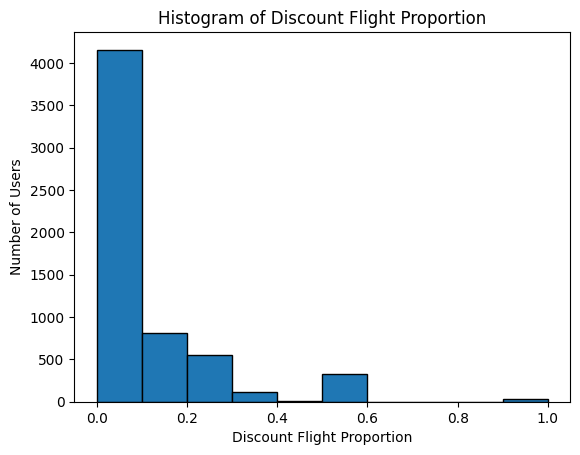

In [7]:
import matplotlib.pyplot as plt

# Create histogram
user_level_df['discount_flight_proportion'].plot(kind='hist', bins=10, edgecolor='black')

# Add labels and title
plt.xlabel('Discount Flight Proportion')
plt.ylabel('Number of Users')
plt.title('Histogram of Discount Flight Proportion')

# Show the plot
plt.show()


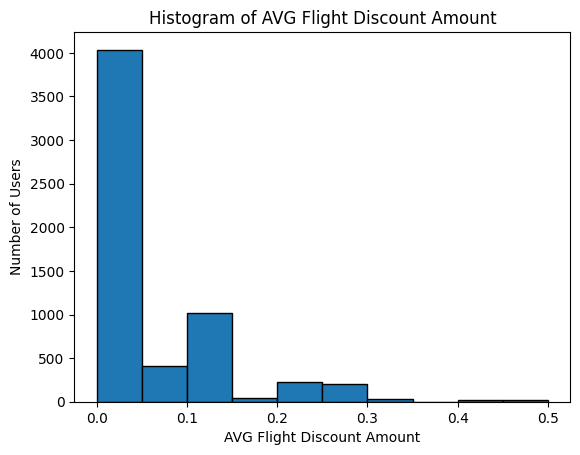

In [8]:
import matplotlib.pyplot as plt

# Create histogram
user_level_df['avg_flight_discount_amount'].plot(kind='hist', bins=10, edgecolor='black')

# Add labels and title
plt.xlabel('AVG Flight Discount Amount')
plt.ylabel('Number of Users')
plt.title('Histogram of AVG Flight Discount Amount')

# Show the plot
plt.show()

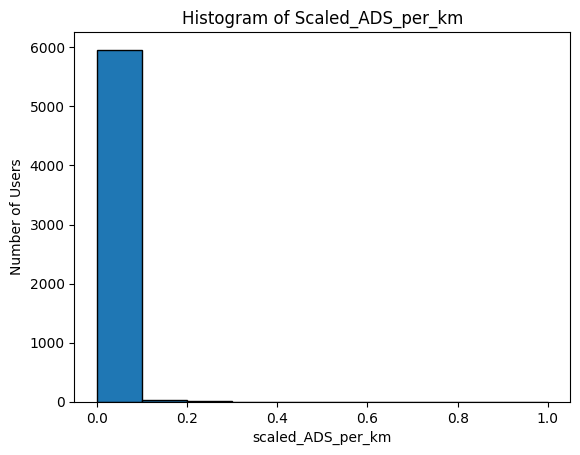

In [32]:
import matplotlib.pyplot as plt

# Create histogram
user_level_df['scaled_ADS'].plot(kind='hist', bins=10, edgecolor='black')

# Add labels and title
plt.xlabel('scaled_ADS_per_km')
plt.ylabel('Number of Users')
plt.title('Histogram of Scaled_ADS_per_km')

# Show the plot
plt.show()

# Final query to create a table including segmentation and perks per customer

In [175]:
# Final query to create a table including the perks per customer

query = """

WITH segmentation_split AS (
    SELECT *,
        CASE
            WHEN trips_booked = 0 AND total_cancellations  = 0 THEN 'Wanderlust Watcher'
            WHEN trips_booked = 0 AND total_cancellations  > 0 THEN 'Last-Minute Leaver'
            WHEN trips_booked > 0 AND has_children = TRUE THEN 'Family Explorer'
            WHEN trips_booked > 0 AND has_children = FALSE AND age_end_july_2023 <= 35 THEN 'Youthful Adventurer'
            WHEN trips_booked > 0 AND has_children = FALSE AND age_end_july_2023 > 55 THEN 'Golden Explorer'
            WHEN trips_booked > 0 AND has_children = FALSE AND age_end_july_2023 BETWEEN 36 AND 55 AND avg_flight_discount_amount = 0 THEN 'Mid-Life Spender'
            WHEN trips_booked > 0 AND has_children = FALSE AND age_end_july_2023 BETWEEN 36 AND 55 AND avg_flight_discount_amount > 0 THEN 'Mid-Life Saver'
            ELSE 'No Perk'
        END AS segmentation
    FROM user_level_df
)
SELECT *,
        CASE
        WHEN segmentation = 'Last-Minute Leaver' THEN 'Free Cancellation'
        WHEN segmentation = 'Family Explorer' THEN 'Kids stay free on next booking flight & hotel combo'
        WHEN segmentation = 'Youthful Adventurer' THEN 'Free bag for all passengers on next flight booking'
        WHEN segmentation = 'Golden Explorer'  THEN '10% discount on next booking made 30 days in advance'
        WHEN segmentation = 'Mid-Life Spender' THEN 'Free meal with next hotel booking' 
        WHEN segmentation = 'Mid-Life Saver' THEN '15% Discount with next booking flight & hotel combo'
        WHEN segmentation = 'Wanderlust Watcher' THEN 'Free drink on next flight'
        ELSE 'No Perk'
    END AS perk
FROM segmentation_split

"""
perk_result = pysqldf(query)
perk_result
perk_result.to_csv('user_level_df_incl_perk_segments.csv', index=False)

In [172]:
# Count per user to check no duplicates and no user has been left out, used a CTE so I can add a rolling total on the perks columns to see total

query = """

WITH count_table AS (
    SELECT COUNT(user_id) AS user_count,
        CASE
            WHEN trips_booked = 0 AND total_cancellations  = 0 THEN 'Wanderlust Watcher'
            WHEN trips_booked = 0 AND total_cancellations  > 0 THEN 'Last-Minute Leaver'
            WHEN trips_booked > 0 AND has_children = TRUE THEN 'Family Explorer'
            WHEN trips_booked > 0 AND has_children = FALSE AND age_end_july_2023 <= 35 THEN 'Youthful Adventurer'
            WHEN trips_booked > 0 AND has_children = FALSE AND age_end_july_2023 > 55 THEN 'Golden Explorer'
            WHEN trips_booked > 0 AND has_children = FALSE AND age_end_july_2023 BETWEEN 36 AND 55 AND avg_flight_discount_amount = 0 THEN 'Mid-Life Spender'
            WHEN trips_booked > 0 AND has_children = FALSE AND age_end_july_2023 BETWEEN 36 AND 55 AND avg_flight_discount_amount > 0 THEN 'Mid-Life Saver'
        END AS segmentation
    FROM user_level_df
    GROUP BY segmentation
)
SELECT 
    segmentation,
    user_count,
    SUM(user_count) OVER(ORDER BY segmentation) AS total
FROM count_table

"""
result1 = pysqldf(query)
result1

,segmentation,user_count,total
0,Family Explorer,1776,1776
1,Golden Explorer,285,2061
2,Last-Minute Leaver,100,2161
3,Mid-Life Saver,931,3092
4,Mid-Life Spender,1459,4551
5,Wanderlust Watcher,456,5007
6,Youthful Adventurer,991,5998


## Code below was for first try at segmentation
* Kept for record puroposes incase I need to change something

In [96]:
#  'Family small Spender' perk - Kids eat free when booking a hotel (Has trips booked, has kids, spent avg of 3000 or less on hotels)

query = """
SELECT COUNT(user_id)
FROM user_level_df
WHERE trips_booked > 0 
    AND has_children = TRUE
    AND avg_hotel_cost_total <= 3000 


"""
result = pysqldf(query)
result

,COUNT(user_id)
0,1728


In [78]:
#  'Big Spender' Perk - 1 night free hotel room with next flight booking (Has trips booked, has no kids, Over 35 years old, has over 4 hotel bookings, has over 9 flights booked)

query = """
SELECT COUNT(user_id)
FROM user_level_df
WHERE trips_booked > 0 
    AND has_children = FALSE
    AND age_end_july_2023 > 35
    AND total_hotel_transactions > 4
    AND total_flights_transactions > 9


"""
result = pysqldf(query)
result

,COUNT(user_id)
0,186


In [79]:
#  'Hotel Stayer' Perk - Free meal booking (Has trips booked, has no kids, Over 35 years old, has 4 or hotel bookings, has 9 or less flights booked)

query = """
SELECT COUNT(user_id)
FROM user_level_df
WHERE trips_booked > 0 
    AND has_children = FALSE
    AND age_end_july_2023 > 35
    AND total_hotel_transactions > 4
    AND total_flights_transactions <= 9


"""
result = pysqldf(query)
result

,COUNT(user_id)
0,127


In [83]:
#  'Mid Life Crisis Travellers' Perk - Bottle of Wine and cheese platter with next hotel booking (Has trips booked, has no kids, Over 35 years old and less then or equal to 50 years old, has 4 or less hotel bookings)

query = """

SELECT COUNT(user_id)
FROM user_level_df
WHERE trips_booked > 0 
    AND has_children = FALSE
    AND age_end_july_2023 > 35
    AND total_hotel_transactions <= 4
    AND age_end_july_2023 <= 50
    
"""
result = pysqldf(query)
result

,COUNT(user_id)
0,1753


In [84]:
#  'Senior Travellers' Perk - 15% off next booking (Has trips booked, has no kids, Over 50 years old, has 4 or less hotel bookings)

query = """

SELECT COUNT(user_id)
FROM user_level_df
WHERE trips_booked > 0 
    AND has_children = FALSE
    AND age_end_july_2023 > 35
    AND total_hotel_transactions <= 4
    AND age_end_july_2023 > 50
    
"""
result = pysqldf(query)
result

,COUNT(user_id)
0,609


In [47]:
#  'Heavy Packer' Perk - Free bag on next flight (Has trips booked, has no kids, 35 years or less, Avg bags over 1)

query = """

SELECT COUNT(user_id)
FROM user_level_df
WHERE trips_booked > 0 
    AND has_children = FALSE
    AND age_end_july_2023 <= 35
    AND avg_checked_bags > 1

    
"""
result = pysqldf(query)
result

,COUNT(user_id)
0,44


In [115]:
#  Young Long Distance traveller - Free bag on next flight (Has trips booked, has no kids, 35 years or less, Avg bags over 1)

query = """

SELECT COUNT(user_id)
FROM user_level_df
WHERE trips_booked > 0 
    AND has_children = FALSE
    AND age_end_july_2023 <= 35
    AND avg_distance_km > 2000

    
"""
result = pysqldf(query)
result

,COUNT(user_id)
0,451


In [111]:
#  'Young short Distance traveller - Free bag on next flight (Has trips booked, has no kids, 35 years or less, Avg bags over 1)

query = """

SELECT COUNT(user_id)
FROM user_level_df
WHERE trips_booked > 0 
    AND has_children = FALSE
    AND age_end_july_2023 <= 35
    AND avg_distance_km <= 4000

    
"""
result = pysqldf(query)
result

,COUNT(user_id)
0,540


In [109]:
#  'Light Packer' Perk - Free drink and snack on next flight booked (Has trips booked, has no kids, 35 years or less, Avg bags 1 or less)

query = """

SELECT COUNT(user_id)
FROM user_level_df
WHERE trips_booked > 0 
    AND has_children = FALSE
    AND age_end_july_2023 <= 35
    AND avg_checked_bags <= 1

    
"""
result = pysqldf(query)
result

,COUNT(user_id)
0,947


In [33]:
#  'Cancellers Fee' Perk -  (Has no trips booked and has cancellations)

query = """

SELECT COUNT(user_id)
FROM user_level_df
WHERE trips_booked = 0 
    AND total_cancellations > 0

"""
result = pysqldf(query)
result

,COUNT(user_id)
0,100


In [34]:
#  'First Time Buyer' Perk -  (Has no trips booked and no cancellations)

query = """

SELECT COUNT(user_id)
FROM user_level_df
WHERE trips_booked = 0 
    AND total_cancellations = 0

"""
result = pysqldf(query)
result

,COUNT(user_id)
0,456


In [136]:
# Count per user to check no duplicates and no user has been left out, used a CTE so I can add a rolling total on the perks columns to see total

query = """

WITH count_table AS (
    SELECT COUNT(user_id) AS user_count,
        CASE
            WHEN trips_booked = 0 AND total_cancellations = 0 THEN 'First Timers - 10% off first booking'
            WHEN trips_booked = 0 AND total_cancellations > 0 THEN 'Non-Committers - Free Cancellation on next booking'
            WHEN trips_booked > 0 AND has_children = TRUE AND avg_hotel_cost_total > 3000 THEN 'Family Big Spenders - Kids stay free next hotel booking'
            WHEN trips_booked > 0 AND has_children = TRUE AND avg_hotel_cost_total <= 3000 THEN 'Family Small Spenders - Kids eat for free next hotel booking'
            WHEN trips_booked > 0 AND has_children = FALSE AND age_end_july_2023 > 35 AND total_hotel_transactions > 4 AND total_flights_transactions > 9 THEN 'Big Spenders - 1 Night free hotel room next flight booking'
            WHEN trips_booked > 0 AND has_children = FALSE AND age_end_july_2023 > 35 AND total_hotel_transactions > 4 AND total_flights_transactions <= 9 THEN 'Hotel Stayers - Free meal with next hotel booking'
            WHEN trips_booked > 0 AND has_children = FALSE AND age_end_july_2023 > 35 AND total_hotel_transactions <= 4 AND age_end_july_2023 > 50 THEN 'Senior Travellers - 15% off next booking'
            WHEN trips_booked > 0 AND has_children = FALSE AND age_end_july_2023 > 35 AND total_hotel_transactions <= 4 AND age_end_july_2023 <= 50 THEN 'Mid Life Travellers - Bottle of Wine and cheese platter with next hotel booking'
            WHEN trips_booked > 0 AND has_children = FALSE AND age_end_july_2023 <= 35 AND avg_checked_bags > 1 THEN 'Heavy Packers - Free bag on next flight'
            WHEN trips_booked > 0 AND has_children = FALSE AND age_end_july_2023 <= 35 AND avg_checked_bags <= 1 THEN 'Light Packers - Free drink and snack on next flight booked'
            ELSE 'No Perk'
        END AS Perks
    FROM user_level_df
    GROUP BY Perks
)
SELECT 
    Perks,
    user_count,
    SUM(user_count) OVER(ORDER BY Perks) AS total
FROM count_table

"""
result1 = pysqldf(query)
result1

,Perks,user_count,total
0,Big Spenders - 1 Night free hotel room next fl...,186,186
1,Family Big Spenders - Kids stay free next hote...,48,234
2,Family Small Spenders - Kids eat for free next...,1728,1962
3,First Timers - 10% off first booking,456,2418
4,Heavy Packers - Free bag on next flight,44,2462
5,Hotel Stayers - Free meal with next hotel booking,127,2589
6,Light Packers - Free drink and snack on next f...,947,3536
7,Mid Life Travellers - Bottle of Wine and chees...,1753,5289
8,Non-Committers - Free Cancellation on next boo...,100,5389
9,Senior Travellers - 15% off next booking,609,5998
